In [18]:
import pandas as pd
import os
import numpy as np
import psycopg2
from psycopg2 import Error



 Pandas library is a good option to use here
- - - 
Working with csv files is really easy when using pandas due to the specific functionalities pandas offers



In [19]:
df = pd.read_csv('dane.csv',sep=';',header=0,encoding='latin1')
#The dataframe needs to be printed to make sure that the data is correct
df

,Nazwa punktu,WspolrzedneNS,WspolrzedneWE,Wysokosc n.p.m.,Data i czas dodania,Metadane
0,Warszawa,52.2297° N,21.0122° E,0.1,06.05.2024 12:00,kraj-Polska
1,Kraków,"50°03'53.0""N","19°56'42.0""E",0.2,06.05.2024 12:05,kraj-Polska
2,Gda?sk,"54°21'07.2""E","18°38'47.8""E",0.3,06.05.2024 12:10,kraj-Polska
3,Wroc?aw,51°06.47333' N,"17°02'18.6""E",0.4,06.05.2024 12:15,kraj-Polska
4,Pozna?,52.4064° N,16.9252° E,0.5,06.05.2024 12:20,kraj-Polska
5,?ód?,"51°45'33.1""N","19°27'21.6""E",0.3,06.05.2024 12:25,kraj-Polska
6,Szczecin,53.7142° N,"14°32'51.0""E",0.2,06.05.2024 12:30,kraj-Polska
7,Katowice,50.2649° N,"19°01'25.7""E",0.4,06.05.2024 12:35,kraj-Polska
8,Gdynia,"54°31'08.0""N","18°31'49.8""E",0.3,06.05.2024 12:40,kraj-Polska
9,Bydgoszcz,53.1235° N,"18°00'30.2""E",0.3,06.05.2024 12:45,kraj-Polska


In [20]:
df.rename(columns={'SzerokoscGEO':'SzerokoscNS','DlugoscGEO':'DlugoscWE'},inplace=True)
df = df.apply(lambda x: x.strip() if type(x) is str else x)
df

,Nazwa punktu,WspolrzedneNS,WspolrzedneWE,Wysokosc n.p.m.,Data i czas dodania,Metadane
0,Warszawa,52.2297° N,21.0122° E,0.1,06.05.2024 12:00,kraj-Polska
1,Kraków,"50°03'53.0""N","19°56'42.0""E",0.2,06.05.2024 12:05,kraj-Polska
2,Gda?sk,"54°21'07.2""E","18°38'47.8""E",0.3,06.05.2024 12:10,kraj-Polska
3,Wroc?aw,51°06.47333' N,"17°02'18.6""E",0.4,06.05.2024 12:15,kraj-Polska
4,Pozna?,52.4064° N,16.9252° E,0.5,06.05.2024 12:20,kraj-Polska
5,?ód?,"51°45'33.1""N","19°27'21.6""E",0.3,06.05.2024 12:25,kraj-Polska
6,Szczecin,53.7142° N,"14°32'51.0""E",0.2,06.05.2024 12:30,kraj-Polska
7,Katowice,50.2649° N,"19°01'25.7""E",0.4,06.05.2024 12:35,kraj-Polska
8,Gdynia,"54°31'08.0""N","18°31'49.8""E",0.3,06.05.2024 12:40,kraj-Polska
9,Bydgoszcz,53.1235° N,"18°00'30.2""E",0.3,06.05.2024 12:45,kraj-Polska


In [21]:
#The values inside the SzerokoscNS and DlugoscWE columns need to be changed to float, so that they can be used in the database
#negative values will be applied to South and West
#positive values will be applied to North and East


#in the function below, the data will be split into various categories based on specific characters present in different formats
def coord_to_float(coords):
    if '"' in coords:
        #format stopnie,minuty,sekundy
        needed_vals,direction = coords.split('"')
        direction = direction.strip()
        needed_vals=needed_vals.replace('°', '\'').strip()
        vals =  needed_vals.strip().split('\'')
        degrees = float(vals[0])
        minutes = float(vals[1])
        seconds = float(vals[2])
        
        #here the negative/positive sign will be determined
        if(direction == 'N' or direction == 'E'):
            multiplier = 1
        else:
            multiplier = -1
        
        return (degrees + (minutes/60) + (seconds/3600)) * multiplier  
                        
        
    elif '\'' in coords:
        #format stopnie,minuty
        needed_vals,direction = coords.split('\'')
        direction = direction.strip()
        vals = needed_vals.strip().split('°')
        degrees = float(vals[0])
        minutes = float(vals[1])
        
        #same as above (negative/positive)
        if(direction == 'N' or direction == 'E'):
            multiplier = 1
        else:
            multiplier = -1
        
        return (degrees + (minutes/60)) * multiplier      
        
        
    elif '°' in coords:
        needed_vals,direction = coords.split('°')
        direction=direction.strip()
        degrees = float(needed_vals.strip())
        if(direction == 'N' or direction == 'E'):
            multiplier = 1
        else:
            multiplier = -1
        return degrees * multiplier        
    else:
        return np.nan()    
    
df[["WspolrzedneNS","WspolrzedneWE"]]=df[["WspolrzedneNS","WspolrzedneWE"]].apply(lambda x : x.apply(coord_to_float))
df

,Nazwa punktu,WspolrzedneNS,WspolrzedneWE,Wysokosc n.p.m.,Data i czas dodania,Metadane
0,Warszawa,52.229700,21.012200,0.1,06.05.2024 12:00,kraj-Polska
1,Kraków,50.064722,19.945000,0.2,06.05.2024 12:05,kraj-Polska
2,Gda?sk,54.352000,18.646611,0.3,06.05.2024 12:10,kraj-Polska
3,Wroc?aw,51.107889,17.038500,0.4,06.05.2024 12:15,kraj-Polska
4,Pozna?,52.406400,16.925200,0.5,06.05.2024 12:20,kraj-Polska
5,?ód?,51.759194,19.456000,0.3,06.05.2024 12:25,kraj-Polska
6,Szczecin,53.714200,14.547500,0.2,06.05.2024 12:30,kraj-Polska
7,Katowice,50.264900,19.023806,0.4,06.05.2024 12:35,kraj-Polska
8,Gdynia,54.518889,18.530500,0.3,06.05.2024 12:40,kraj-Polska
9,Bydgoszcz,53.123500,18.008389,0.3,06.05.2024 12:45,kraj-Polska


In [22]:
#the date and time will be converted to a datetime object
df["Data i czas dodania"] = pd.to_datetime(df["Data i czas dodania"],format='%d.%m.%Y %H:%M')
df


,Nazwa punktu,WspolrzedneNS,WspolrzedneWE,Wysokosc n.p.m.,Data i czas dodania,Metadane
0,Warszawa,52.229700,21.012200,0.1,2024-05-06 12:00:00,kraj-Polska
1,Kraków,50.064722,19.945000,0.2,2024-05-06 12:05:00,kraj-Polska
2,Gda?sk,54.352000,18.646611,0.3,2024-05-06 12:10:00,kraj-Polska
3,Wroc?aw,51.107889,17.038500,0.4,2024-05-06 12:15:00,kraj-Polska
4,Pozna?,52.406400,16.925200,0.5,2024-05-06 12:20:00,kraj-Polska
5,?ód?,51.759194,19.456000,0.3,2024-05-06 12:25:00,kraj-Polska
6,Szczecin,53.714200,14.547500,0.2,2024-05-06 12:30:00,kraj-Polska
7,Katowice,50.264900,19.023806,0.4,2024-05-06 12:35:00,kraj-Polska
8,Gdynia,54.518889,18.530500,0.3,2024-05-06 12:40:00,kraj-Polska
9,Bydgoszcz,53.123500,18.008389,0.3,2024-05-06 12:45:00,kraj-Polska


# Saving the cleaned data to a database

The DBMS used here is PostGreSQL since it is open-source
- - - 

In order for code below to work, the person checking this will need to have postGreSQL installed on their machine
and will need to create a .env file in the same directory where the ipynb file will be stored
The .env file will need to contain variables:
1) DB_USER (username)
2) DB_PASSWORD (DB password)
3) DB_HOST (host name)
4) DB_PORT (port)
5) DB_DATABASE (database to connect to)

In [23]:
#df.to_sql('dane', conn, if_exists='replace', index=False)
df.dtypes
import psycopg2
from psycopg2 import Error
from dotenv import load_dotenv
load_dotenv()


try:
    connection = psycopg2.connect(user=os.getenv('DB_USER'),
                                  password=os.getenv('DB_PASSWORD'),
                                  host=os.getenv('DB_HOST'),
                                  port=os.getenv('DB_PORT'),
                                  database=os.getenv('DB_DATABASE'))
    
    cur = connection.cursor()
    print("PostgreSQL server information")
    print(connection.get_dsn_parameters(), "\n")
    cur.execute("SELECT version();")
    record = cur.fetchone()
    print("You are connected to - ", record, "\n")
    
    cur.execute("DROP TABLE IF EXISTS dane;")
    cur.execute('''
                CREATE TABLE dane(
                    nazwa_punktu VARCHAR(255),
                    wspolrzedneNS FLOAT,
                    wspolrzedneWE FLOAT,
                    wysokosc_npm FLOAT,
                    data_i_czas_dodania TIMESTAMP,
                    metadane VARCHAR(255));''')
    connection.commit()
    
    for index,row in df.iterrows():
        cur.execute('''
                    INSERT INTO dane(nazwa_punktu,wspolrzedneNS,wspolrzedneWE,wysokosc_npm,data_i_czas_dodania,metadane)
                    VALUES (%s,%s,%s,%s,%s,%s);''',
                    (row['Nazwa punktu'],row['WspolrzedneNS'],row['WspolrzedneWE'],row['Wysokosc n.p.m.'],row['Data i czas dodania'],row['Metadane']))
    connection.commit()
        
except (Exception, Error) as error:
    print("Error while connecting to PostgreSQL", error)
finally:
    if connection:
        connection.close()
        print("PostgreSQL connection is closed")    


PostgreSQL server information
{'user': 'postgres', 'channel_binding': 'prefer', 'dbname': 'exatelproject', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslcertmode': 'allow', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'disable', 'krbsrvname': 'postgres', 'gssdelegation': '0', 'target_session_attrs': 'any', 'load_balance_hosts': 'disable'} 

You are connected to -  ('PostgreSQL 15.3, compiled by Visual C++ build 1914, 64-bit',) 

PostgreSQL connection is closed


# Calculating the perimeter of the Convex Polygon
- - -
The convex polygon is a closed figure that has data points enclosed within it. It's possible to find the best (smallest) convext polygon and calculate its perimeter

In [24]:
from scipy.spatial import ConvexHull

points = df[['WspolrzedneWE','WspolrzedneNS']].values
hull = ConvexHull(points)


1802.319166781304


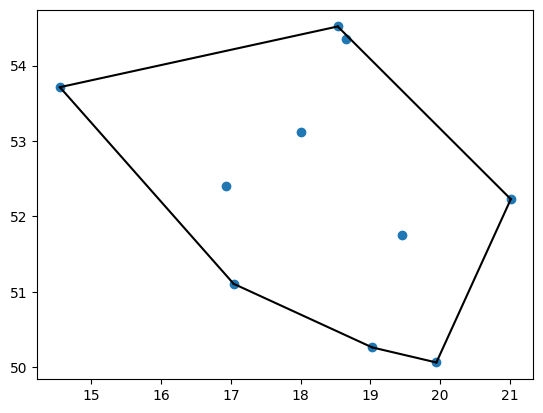

In [25]:
import matplotlib.pyplot as plt
from geopy.distance import geodesic

#The data is being plotted to visually veryfy the correctness of the convex hull
plt.plot(points[:,0], points[:,1], 'o')#plots the points

perimeter = 0

for simplex in hull.simplices:
    #the loop iterates over the simplices of the convex hull
    #it retrieves the coords of the points then calculates the geodesic distance between them
    x = points[simplex[0]]
    y = points[simplex[1]]
    distance = geodesic(x,y).kilometers
    perimeter += distance
    plt.plot(points[simplex,0],points[simplex,1], 'k-')#plots the convex hull
print(perimeter)    


# Visualizing the data in the form of a Mercator world map containing plotted points

In [26]:
try:
    connection = psycopg2.connect(user=os.getenv('DB_USER'),
                                  password=os.getenv('DB_PASSWORD'),
                                  host=os.getenv('DB_HOST'),
                                  port=os.getenv('DB_PORT'),
                                  database=os.getenv('DB_DATABASE'))
    
    cur = connection.cursor()
    print("PostgreSQL server information")
    print(connection.get_dsn_parameters(), "\n")
    cur.execute("SELECT version();")
    record = cur.fetchone()
    print("You are connected to - ", record, "\n")
    
    cur.execute("Select wspolrzednens,wspolrzednewe from dane;")
    rows = cur.fetchall()
    latitude = list()
    longitude = list()
    for row in rows:
        #the data is being retrieved from the database and stored in two lists 
        #which will be used as plotted data points
        latitude.append(row[0])
        longitude.append(row[1])
    cur.close()    
        
    
except (Exception, Error) as error:
    print("Error while connecting to PostgreSQL", error)
finally:
    if connection:
        connection.close()
        print("PostgreSQL connection is closed")    
        
    
    

PostgreSQL server information
{'user': 'postgres', 'channel_binding': 'prefer', 'dbname': 'exatelproject', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslcertmode': 'allow', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'disable', 'krbsrvname': 'postgres', 'gssdelegation': '0', 'target_session_attrs': 'any', 'load_balance_hosts': 'disable'} 

You are connected to -  ('PostgreSQL 15.3, compiled by Visual C++ build 1914, 64-bit',) 

PostgreSQL connection is closed


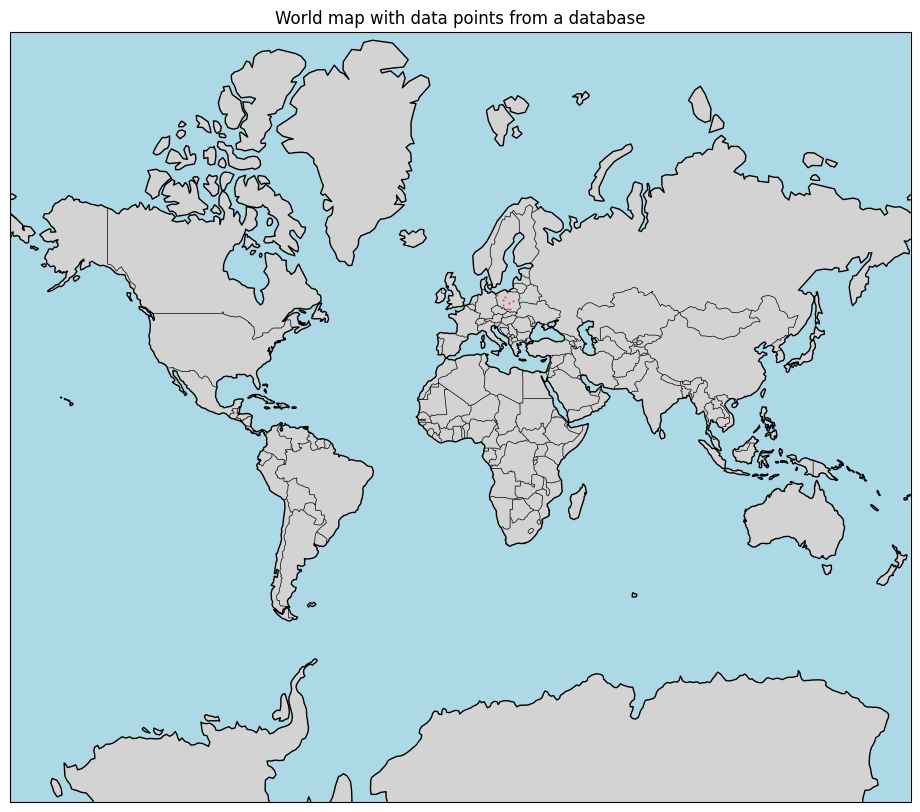

In [27]:
import cartopy.crs as ccrs
import cartopy.feature

fig = plt.figure(figsize=(30, 10))
axes = plt.subplot(projection=ccrs.Mercator())
axes.set_global()
axes.set_title('World map with data points from a database')
axes.coastlines()
axes.add_feature(cartopy.feature.BORDERS,linewidth=0.5,edgecolor='black')
axes.add_feature(cartopy.feature.LAND,facecolor='lightgrey')
axes.add_feature(cartopy.feature.OCEAN,facecolor='lightblue')
axes.scatter(longitude,latitude,color='red',marker='.',transform=ccrs.PlateCarree(),label='Data points',s=.5)


